# 1. Import libraries

In [77]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd
from rdkit import Chem
from rdkit import RDLogger

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

RDLogger.DisableLog('rdApp.*')    




import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, Parameter, Bilinear

from torch_scatter import scatter
from torch_geometric.nn import global_add_pool, GATConv
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import glorot, reset
from torch_geometric.nn.pool.pool import pool_batch
from torch_geometric.nn.pool.consecutive import consecutive_cluster



# 2. Load dataset 

In [2]:
# # -------------------------------
# # Step 1. Convert SMILES to Graph
# # -------------------------------
# def smiles_to_data(smiles, label):
#     """
#     Convert a SMILES string to a PyTorch Geometric Data object.
#     Here, each atom is a node with a simple feature (atomic number).
#     Edges are added for every bond in both directions.
#     """
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None  # Skip invalid molecules

#     # Create node features: using the atomic number as a feature
#     atom_features = []
#     for atom in mol.GetAtoms():
#         # You can extend this list with additional features as needed.
#         atom_features.append([atom.GetAtomicNum()])
#     x = torch.tensor(atom_features, dtype=torch.float)

#     # Create edge_index from bonds
#     edge_index = []
#     for bond in mol.GetBonds():
#         start = bond.GetBeginAtomIdx()
#         end = bond.GetEndAtomIdx()
#         edge_index.append([start, end])
#         edge_index.append([end, start])
#     if len(edge_index) > 0:
#         edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#     else:
#         # For molecules with no bonds, create an empty edge_index
#         edge_index = torch.empty((2, 0), dtype=torch.long)

#     # Create the label tensor (for classification)
#     # Adjust dtype if you are doing regression (e.g. torch.float)

#     y = torch.tensor([label], dtype=torch.long)
    
#     data = Data(x=x, edge_index=edge_index, y=y)
#     return data

In [68]:
from rdkit import Chem
import torch
from torch_geometric.data import Data
import numpy as np

def smiles_to_data(smiles, label):
    """
    Convert a SMILES string to a PyTorch Geometric Data object.
    Each atom is a node with its atomic number as a feature.
    Edges are bonds, and edge_attr includes bond type as one-hot vectors.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Skip invalid molecules

    # Create node features: using the atomic number as a feature
    atom_features = [[atom.GetAtomicNum()] for atom in mol.GetAtoms()]
    x = torch.tensor(atom_features, dtype=torch.float)

    # Create edge_index and edge_attr
    edge_index = []
    edge_attr = []
    bond_type_to_feature = {
        Chem.rdchem.BondType.SINGLE: [1, 0, 0, 0],
        Chem.rdchem.BondType.DOUBLE: [0, 1, 0, 0],
        Chem.rdchem.BondType.TRIPLE: [0, 0, 1, 0],
        Chem.rdchem.BondType.AROMATIC: [0, 0, 0, 1]
    }
    
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_type = bond.GetBondType()
        edge_feature = bond_type_to_feature.get(bond_type, [0, 0, 0, 0])  # Default to [0,0,0,0] if unknown
        
        edge_index.append([start, end])
        edge_index.append([end, start])
        edge_attr.append(edge_feature)
        edge_attr.append(edge_feature)  # Undirected graph
    
    if edge_index:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)
        edge_attr = torch.empty((0, 4), dtype=torch.float)  # Shape (num_edges, num_features)

    # Create the label tensor (for classification)
    y = torch.tensor([label], dtype=torch.long)
    
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    return data


In [69]:
# -----------------------------------------
# Step 2. Load Dataset and Convert to Graphs
# -----------------------------------------
# Assume your CSV has columns: 'smiles' and 'label'
df = pd.read_csv("toxcast_data.csv")
print(f"Number of rows in original dataset: {df.shape[0]}")
print(f"Number of tasks: {df.shape[1] - 1}")
print(f"Some Tasks: {list(df.columns.values)[1:5]}")

Number of rows in original dataset: 8597
Number of tasks: 617
Some Tasks: ['ACEA_T47D_80hr_Negative', 'ACEA_T47D_80hr_Positive', 'APR_HepG2_CellCycleArrest_24h_dn', 'APR_HepG2_CellCycleArrest_24h_up']


In [70]:
# label_name = "BSK_CASM3C_Thrombomodulin_down"
label_name = "CLD_CYP1A2_48hr"
labels = []
data_list = []

for idx, row in df.iterrows():
    # print(row["ACEA_T47D_80hr_Negative"], pd.isna(row["ACEA_T47D_80hr_Negative"]))
    if not(pd.isna(row[label_name])):
        data_obj = smiles_to_data(row['smiles'], row[label_name])
        if data_obj is not None:
            print(data_obj)
            labels.append(data_obj.y)
            data_list.append(data_obj)

print(f"Number of rows after preprocessing: {len(data_list)}")


# (Optional) Split into train and test sets
batch_size = 32
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=42, stratify=labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Data(x=[4, 1], edge_index=[2, 6], edge_attr=[6, 4], y=[1])
Data(x=[11, 1], edge_index=[2, 22], edge_attr=[22, 4], y=[1])
Data(x=[28, 1], edge_index=[2, 58], edge_attr=[58, 4], y=[1])
Data(x=[16, 1], edge_index=[2, 34], edge_attr=[34, 4], y=[1])
Data(x=[13, 1], edge_index=[2, 26], edge_attr=[26, 4], y=[1])
Data(x=[27, 1], edge_index=[2, 56], edge_attr=[56, 4], y=[1])
Data(x=[14, 1], edge_index=[2, 28], edge_attr=[28, 4], y=[1])
Data(x=[7, 1], edge_index=[2, 12], edge_attr=[12, 4], y=[1])
Data(x=[26, 1], edge_index=[2, 58], edge_attr=[58, 4], y=[1])
Data(x=[20, 1], edge_index=[2, 42], edge_attr=[42, 4], y=[1])
Data(x=[23, 1], edge_index=[2, 48], edge_attr=[48, 4], y=[1])
Data(x=[25, 1], edge_index=[2, 54], edge_attr=[54, 4], y=[1])
Data(x=[24, 1], edge_index=[2, 50], edge_attr=[50, 4], y=[1])
Data(x=[5, 1], edge_index=[2, 8], edge_attr=[8, 4], y=[1])
Data(x=[27, 1], edge_index=[2, 58], edge_attr=[58, 4], y=[1])
Data(x=[31, 1], edge_index=[2, 66], edge_attr=[66, 4], y=[1])
Data(x=[16, 1],

In [71]:
ones = [1 for sample in data_list if sample.y == 1]
zeros = [0 for sample in data_list if sample.y == 0]
print(len(ones), len(zeros))

153 147


In [72]:
train_ones = [1 for sample in train_data if sample.y == 1]
train_zeros = [0 for sample in train_data if sample.y == 0]
test_ones = [1 for sample in test_data if sample.y == 1]
test_zeros = [0 for sample in test_data if sample.y == 0]

In [73]:
print(f"Number of training data: {len(train_data)}")
print(f"    - Number of ones: {len(train_ones)}")
print(f"    - Number of zeros: {len(train_zeros)}")
print(f"Number of test data: {len(test_data)}")
print(f"    - Number of ones: {len(test_ones)}")
print(f"    - Number of zeros: {len(test_zeros)}")

Number of training data: 240
    - Number of ones: 122
    - Number of zeros: 118
Number of test data: 60
    - Number of ones: 31
    - Number of zeros: 29


# 3. Train model

In [64]:
# # -------------------------------
# # Step 3. Define the GAT Model
# # -------------------------------
# # Reference: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py

# class GAT(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
#         """
#         A GAT model for graph-level classification.
#         Two GAT layers are used, followed by global mean pooling and a linear layer.
#         """
#         super(GAT, self).__init__()
#         self.dropout = dropout
#         # First GAT layer; note that multiple heads yield hidden_channels * heads output features.
#         self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
#         # Second GAT layer; using a single head and not concatenating.
#         self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
#         # Final linear layer for graph-level prediction
#         self.lin = torch.nn.Linear(hidden_channels, out_channels)

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch  # data.batch is added by the DataLoader
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.conv2(x, edge_index)
#         # Global pooling: aggregates node features to a graph-level representation
#         x = global_mean_pool(x, batch)
#         x = self.lin(x)
#         return F.log_softmax(x, dim=1)

# # Set hyperparameters (adjust as needed)
# in_channels = 1             # We use the atomic number as the sole feature
# hidden_channels = 8
# num_classes = df[label_name].nunique()  # Number of classes in your dataset
# heads = 8
# dropout = 0.6

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GAT(in_channels, hidden_channels, num_classes, heads=heads, dropout=dropout).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

In [84]:
# ---------------------------------------
# Attention layers
# ---------------------------------------
class FeatureAttention(nn.Module):
    def __init__(self, channels, reduction):
        super().__init__()
        self.mlp = Sequential(
            Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            Linear(channels // reduction, channels, bias=False),
        )

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.mlp)

    def forward(self, x, batch, size=None):
        max_result = scatter(x, batch, dim=0, dim_size=size, reduce='max')
        sum_result = scatter(x, batch, dim=0, dim_size=size, reduce='sum')
        max_out = self.mlp(max_result)
        sum_out = self.mlp(sum_result)
        y = torch.sigmoid(max_out + sum_out)
        y = y[batch]
        return x * y


# ---------------------------------------
# Neural tensor networks conv
# ---------------------------------------
class NTNConv(MessagePassing):

    def __init__(self, in_channels, out_channels, slices, dropout, edge_dim=None, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(NTNConv, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.slices = slices
        self.dropout = dropout
        self.edge_dim = edge_dim

        self.weight_node = Parameter(torch.Tensor(in_channels,
                                                  out_channels))
        if edge_dim is not None:
            self.weight_edge = Parameter(torch.Tensor(edge_dim,
                                                      out_channels))
        else:
            self.weight_edge = self.register_parameter('weight_edge', None)

        self.bilinear = Bilinear(out_channels, out_channels, slices, bias=False)

        if self.edge_dim is not None:
            self.linear = Linear(3 * out_channels, slices)
        else:
            self.linear = Linear(2 * out_channels, slices)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight_node)
        glorot(self.weight_edge)
        self.bilinear.reset_parameters()
        self.linear.reset_parameters()

    def forward(self, x, edge_index, edge_attr=None, return_attention_weights=None):

        x = torch.matmul(x, self.weight_node)

        if self.weight_edge is not None:
            assert edge_attr is not None
            edge_attr = torch.matmul(edge_attr, self.weight_edge)

        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)

        alpha = self._alpha
        self._alpha = None

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            return out, (edge_index, alpha)
        else:
            return out

    def message(self, x_i, x_j, edge_attr):
        score = self.bilinear(x_i, x_j)
        if edge_attr is not None:
            vec = torch.cat((x_i, edge_attr, x_j), 1)
            block_score = self.linear(vec)  # bias already included
        else:
            vec = torch.cat((x_i, x_j), 1)
            block_score = self.linear(vec)
        scores = score + block_score
        alpha = torch.tanh(scores)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        dim_split = self.out_channels // self.slices
        out = torch.max(x_j, edge_attr).view(-1, self.slices, dim_split)

        out = out * alpha.view(-1, self.slices, 1)
        out = out.view(-1, self.out_channels)
        return out

class CustomGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, edge_dim, num_layers,
                 slices, dropout, f_att=False, r=4):
        super(CustomGNN, self).__init__()

        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.dropout = dropout

        self.f_att = f_att

        # atom feature transformation
        self.lin_a = Linear(in_channels, hidden_channels)
        self.lin_b = Linear(edge_dim, hidden_channels)

        # convs block
        self.atom_convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = NTNConv(hidden_channels, hidden_channels, slices=slices,
                           dropout=dropout, edge_dim=hidden_channels)
            self.atom_convs.append(conv)

        self.lin_gate = Linear(3 * hidden_channels, hidden_channels)

        if self.f_att:
            self.feature_att = FeatureAttention(channels=hidden_channels, reduction=r)

        self.out = Linear(hidden_channels, out_channels)
        self.reset_parameters()

    def reset_parameters(self):

        self.lin_a.reset_parameters()
        self.lin_b.reset_parameters()

        for conv in self.atom_convs:
            conv.reset_parameters()

        self.lin_gate.reset_parameters()

        if self.f_att:
            self.feature_att.reset_parameters()

        self.out.reset_parameters()

    def forward(self, data):
        # get mol input
        x = data.x
        edge_index = data.edge_index
        edge_attr = data.edge_attr
        batch = data.batch

        x = F.relu(self.lin_a(x))  # (N, 46) -> (N, hidden_channels)
        edge_attr = F.relu(self.lin_b(edge_attr))  # (N, 10) -> (N, hidden_channels)

        # mol conv block
        for i in range(0, self.num_layers):
            h = F.relu(self.atom_convs[i](x, edge_index, edge_attr))
            beta = self.lin_gate(torch.cat([x, h, x - h], 1)).sigmoid()
            x = beta * x + (1 - beta) * h
            if self.f_att:
                x = self.feature_att(x, batch)

        mol_vec = global_add_pool(x, batch).relu_()
        out = F.dropout(mol_vec, p=self.dropout, training=self.training)
        return self.out(out)


class FocalLoss(nn.Module):
    '''
    Multi-class Focal Loss
    '''
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        """
        input: [N, C], float32
        target: [N, ], int64
        """
        logpt = F.log_softmax(input, dim=1)
        pt = torch.exp(logpt)
        logpt = (1-pt)**self.gamma * logpt
        loss = F.nll_loss(logpt, target, self.weight)
        return loss


model = CustomGNN(in_channels=1,
                  hidden_channels=128,
                  out_channels=2,
                  edge_dim=4,
                  num_layers=3,
                  dropout=0.3,
                  slices=2,
                  f_att=True,
                  r=4,
                )
# model.train()
# model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
criterion = FocalLoss()

In [85]:
# -------------------------------
# Step 4. Training and Evaluation
# -------------------------------
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        # loss = F.nll_loss(out, data.y.view(-1))
        loss = criterion(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    y_pred, y_true = [], []

    for data in loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1)
        y_pred.extend(pred.tolist())
        y_true.extend(data.y.view(-1).tolist())
        correct += (pred == data.y.view(-1)).sum().item()
    # print(len(y_pred), len(y_true), len(loader.dataset))
    # print(y_pred, y_true)
    auc = roc_auc_score(y_true, y_pred)
    cf = confusion_matrix(y_true, y_pred)
    return correct / len(loader.dataset), auc, cf

# Training loop
num_epochs = 1000
for epoch in range(1, num_epochs + 1):
    loss = train()
    test_acc, test_auc, test_cf = test(test_loader)
    train_acc, train_auc, train_cf = test(train_loader)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        print(f'    - Train Acc {train_acc:.4f}, Train AUC: {train_auc:.4f}')
        print(f'    - Test Acc: {test_acc:.4f}, Test AUC: {test_auc:.4f}')

Epoch: 010, Loss: 0.3105
    - Train Acc 0.5625, Train AUC: 0.5630
    - Test Acc: 0.5500, Test AUC: 0.5467
Epoch: 020, Loss: 0.2880
    - Train Acc 0.5125, Train AUC: 0.5083
    - Test Acc: 0.5500, Test AUC: 0.5445
Epoch: 030, Loss: 0.1780
    - Train Acc 0.5375, Train AUC: 0.5426
    - Test Acc: 0.4000, Test AUC: 0.4127
Epoch: 040, Loss: 0.1720
    - Train Acc 0.6375, Train AUC: 0.6373
    - Test Acc: 0.6167, Test AUC: 0.6112
Epoch: 050, Loss: 0.1704
    - Train Acc 0.6167, Train AUC: 0.6149
    - Test Acc: 0.5833, Test AUC: 0.5745
Epoch: 060, Loss: 0.1661
    - Train Acc 0.6250, Train AUC: 0.6228
    - Test Acc: 0.5500, Test AUC: 0.5412
Epoch: 070, Loss: 0.1658
    - Train Acc 0.6042, Train AUC: 0.6005
    - Test Acc: 0.5500, Test AUC: 0.5367
Epoch: 080, Loss: 0.1637
    - Train Acc 0.6208, Train AUC: 0.6157
    - Test Acc: 0.5667, Test AUC: 0.5517
Epoch: 090, Loss: 0.1607
    - Train Acc 0.6417, Train AUC: 0.6377
    - Test Acc: 0.5500, Test AUC: 0.5367
Epoch: 100, Loss: 0.1589
   

Final result:
- Train Acc 0.7625, Train AUC: 0.7613
- Train confusion matrix:


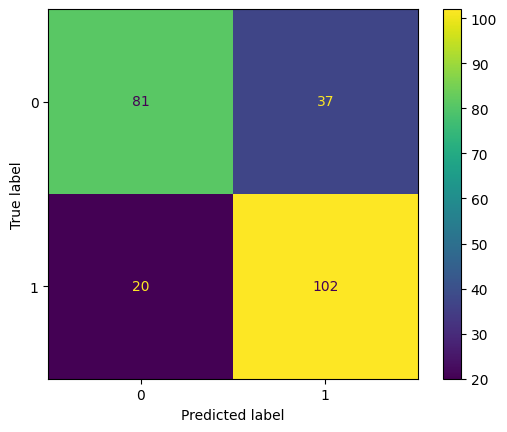

- Test Acc 0.6333, Test AUC: 0.6251
- Test confusion matrix:


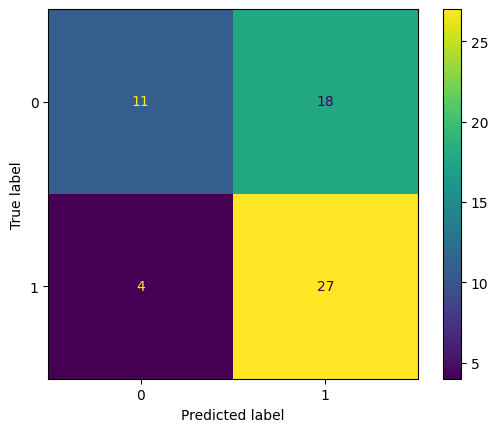

In [86]:
print(f'Final result:')
print(f'- Train Acc {train_acc:.4f}, Train AUC: {train_auc:.4f}')
print(f'- Train confusion matrix:')
traindisp = ConfusionMatrixDisplay(confusion_matrix=train_cf, display_labels=['0', '1'])
traindisp.plot()
plt.show()
print(f'- Test Acc {test_acc:.4f}, Test AUC: {test_auc:.4f}')
print(f'- Test confusion matrix:')
testdisp = ConfusionMatrixDisplay(confusion_matrix=test_cf, display_labels=['0', '1'])
testdisp.plot()
plt.show()


# 4. Full pipeline

In [66]:
def get_data_distribution(df):
    best_dist = []
    for task in list(df.columns.values)[1:]:
        # print(f"Processing {task}...")
        # data_list = []
        zeros = df[task].value_counts(dropna=True)[0]
        ones = df[task].value_counts(dropna=True)[1]
                
        dist = ones / (ones+zeros)
        # print(f"Total: {ones+zeros}, ones: {ones}, ratio: {dist}")
        if dist > 0.5:
            best_dist.append((task, dist))
    # print(f"Best task: {_label}, distribution: {best_dist}")
    return best_dist
best_dist = get_data_distribution(df)

print(f"Number of tasks: {len(best_dist)}, Best task: {best_dist}")

Number of tasks: 77, Best task: [('CLD_CYP1A2_48hr', 0.5148514851485149), ('CLD_CYP2B6_24hr', 0.5761589403973509), ('CLD_CYP2B6_48hr', 0.5412541254125413), ('CLD_CYP2B6_6hr', 0.6032786885245902), ('NCCT_HEK293T_CellTiterGLO', 0.5386666666666666), ('NCCT_QuantiLum_inhib_dn', 0.5517241379310345), ('NCCT_TPO_AUR_dn', 0.824), ('NCCT_TPO_GUA_dn', 0.5849056603773585), ('NHEERL_ZF_144hpf_TERATOSCORE_up', 0.6878531073446328), ('NVS_ADME_hCYP1A2', 0.7745664739884393), ('NVS_ADME_hCYP2B6', 0.7463768115942029), ('NVS_ADME_hCYP2C19', 0.8010471204188482), ('NVS_ADME_hCYP2C9', 0.831858407079646), ('NVS_ADME_hCYP2D6', 0.6837606837606838), ('NVS_ADME_hCYP3A4', 0.5341614906832298), ('NVS_ADME_rCYP2C12', 0.5818181818181818), ('NVS_ENZ_hBACE', 0.5294117647058824), ('NVS_ENZ_hDUSP3', 0.5865384615384616), ('NVS_ENZ_hES', 0.5030674846625767), ('NVS_ENZ_hMMP13', 0.5487804878048781), ('NVS_ENZ_hPTPRC', 0.5671641791044776), ('NVS_ENZ_oCOX1', 0.6), ('NVS_ENZ_oCOX2', 0.5922330097087378), ('NVS_ENZ_rMAOAC', 0.730

Number of rows after preprocessing: 1732
